In [1]:
import pandas as pd
import numpy as np

In [7]:
%%time
twitter = pd.read_csv("final_dataset.csv")   

Wall time: 5.08 s


In [8]:
pd.set_option('display.max_rows', 1000)
twitter

,_score,tweet_id,text,identification,emotion,text_stemmed,Category
0,391,0x376b20,people who post add me on snapchat must be deh...,train,anticipation,peopl who post add me on snapchat must be dehy...,4
1,433,0x2d5350,brianklaas as we see trump is dangerous to fre...,train,sadness,brianklaa as we see trump is danger to freepre...,8
2,376,0x1cd5b0,now issa is stalking tasha 😂😂😂,train,fear,now issa is stalk tasha 😂😂😂,1
3,120,0x1d755c,riskshow thekevinallison thx for the best time...,train,joy,riskshow thekevinallison thx for the best time...,7
4,1021,0x2c91a8,still waiting on those supplies liscus,train,anticipation,still wait on those suppli liscu,4
...,...,...,...,...,...,...,...
1451386,94,0x321566,im so happy nowonder the name of this show hap...,train,joy,im so happi nowond the name of thi show happi ...,7
1451387,627,0x38959e,in every circumtance id like to be thankful to...,train,joy,in everi circumt id like to be thank to the al...,7
1451388,274,0x2cbca6,theres currently two girls walking around the ...,train,joy,there current two girl walk around the librari...,7
1451389,840,0x24faed,ah corporate life where you can date using ju...,train,joy,ah corpor life where you can date use just the...,7


In [9]:
#use only subset of data in order to speed up trainning
#twitter = twitter[:5000]


In [10]:
%%time
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
twitter.text = twitter.text.astype(str)
tokenizer.fit_on_texts(twitter['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 926218 unique tokens.
Wall time: 23.2 s


In [11]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(twitter['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1451391, 250)


In [12]:
Y = pd.get_dummies(twitter['emotion']).values
print('Shape of label tensor:', Y.shape)
Y

Shape of label tensor: (1451391, 8)


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1306251, 250) (1306251, 8)
(145140, 250) (145140, 8)


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  Embedding, SpatialDropout1D, Dense
from tensorflow.keras.layers import LSTM


model = keras.Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 128 #64 is original

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[tf.keras.callbacks.EarlyStopping
(monitor='val_loss',mode='max', patience=1, min_delta=0.0001)])

Epoch 1/2
  44/9185 [..............................] - ETA: 3:41:47 - loss: 1.8677 - accuracy: 0.3350

KeyboardInterrupt: 

In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16/16 [==============================] - 0s 23ms/step - loss: 2.3288 - accuracy: 0.3140
Test set
  Loss: 2.329
  Accuracy: 0.314


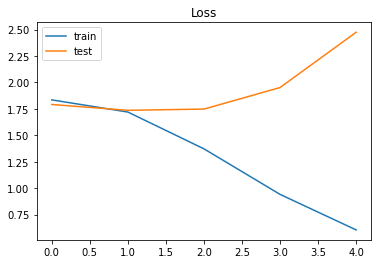

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

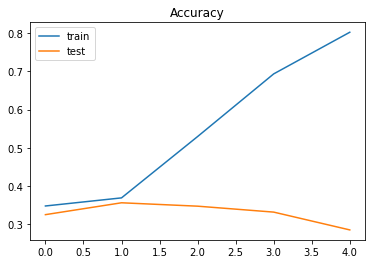

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [11]:
new_complaint = ['joy']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness','surprise', 'trust']
print(labels[np.argmax(pred)])

sadness


In [12]:
pred = model.predict(X_test, batch_size=64) #64
pred_res=[]
ground_truth=[]

for p in pred :
    pred_res.append(labels[np.argmax(p)])
    
for y in Y_test :
    ground_truth.append(labels[np.argmax(y)])

In [13]:
match = 0
for i in range(len(pred_res)):
    if pred_res[i]==ground_truth[i]:
        match += 1
print(match/len(pred_res))

0.314


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        18
anticipation       0.30      0.29      0.29        76
     disgust       0.12      0.22      0.15        36
        fear       1.00      0.13      0.23        23
         joy       0.55      0.40      0.46       193
     sadness       0.26      0.33      0.29        63
    surprise       0.00      0.00      0.00        18
       trust       0.19      0.36      0.25        73

    accuracy                           0.31       500
   macro avg       0.30      0.22      0.21       500
weighted avg       0.37      0.31      0.32       500

**************************************************************
Normalized confusion matrix
[[0.         0.11111111 0.27777778 0.         0.11111111 0.27777778
  0.         0.22222222]
 [0.         0.28947368 0.09210526 0.         0.22368421 0.07894737
  0.         0.31578947]
 [0.         0.05555556 0.22222222 0.         0.25       0.19444444
  0.

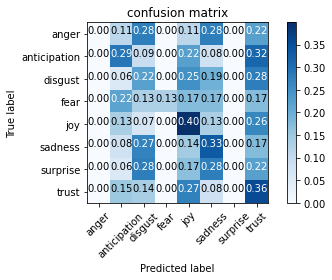

In [14]:
from sklearn.metrics import classification_report

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
print(classification_report(ground_truth, pred_res, target_names=labels))
print ("**************************************************************")

plt.figure()
cnf_matrix = confusion_matrix(ground_truth, pred_res)
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                    title= 'confusion matrix')

plt.show()
    
    

In [15]:
%%time
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords

twitter_test_data = pd.read_csv("twitter_test_data.csv")

stop = set(stopwords.words("english"))

def stemming(sentence):
    ps = PorterStemmer()
    words = word_tokenize(sentence)
    res = []
    for w in words:
        res.append(ps.stem(w))
    return ' '.join(res)


def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)



def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

twitter_test_data["text"] = twitter_test_data.text.apply(stemming)
twitter_test_data["text"] = twitter_test_data.text.apply(remove_URL)
twitter_test_data["text"] = twitter_test_data.text.apply(remove_html)
twitter_test_data["text"] = twitter_test_data.text.apply(remove_emoji)
twitter_test_data["text"] = twitter_test_data.text.apply(remove_punct)
twitter_test_data["text"] = twitter_test_data.text.apply(remove_stopwords)

twitter_test_data


Wall time: 2min 45s


,_score,tweet_id,text,identification
0,232,0x28b412,confid obedi write know even ask philemon 121 ...,test
1,989,0x2de201,trust faith friend someon trust put faith anyo...,test
2,66,0x218443,enough satisfi goal realli money materi money ...,test
3,104,0x2939d5,god woke chase day godsplan godswork,test
4,310,0x26289a,tough time turn symbol hope,test
...,...,...,...,...
411967,602,0x2913b4,thi messag ye heard begin love one anoth john ...,test
411968,598,0x2a980e,lad hath five barley loav two small fish among...,test
411969,827,0x316b80,buy last 2 ticket remain show sell mixedfeel b...,test
411970,368,0x29d0cb,swear thi hard work gone pay one day,test


In [16]:
seq = tokenizer.texts_to_sequences(twitter_test_data.text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
padded

array([[   0,    0,    0, ...,   24,   68,  152],
       [   0,    0,    0, ...,  199,  828, 6434],
       [   0,    0,    0, ..., 2938,  150, 2087],
       ...,
       [   0,    0,    0, ...,  788,   69,  177],
       [   0,    0,    0, ...,  282,   13,    5],
       [   0,    0,    0, ...,    9,  468,    6]])

In [17]:
pred = model.predict(padded, batch_size=64) #64

In [18]:
public_pred = []
for p in pred:
    public_pred.append(labels[np.argmax(p)])

In [19]:
upload_df = pd.DataFrame()
upload_df["id"] = twitter_test_data["tweet_id"]
upload_df["emotion"] = public_pred
upload_df

,id,emotion
0,0x28b412,trust
1,0x2de201,trust
2,0x218443,disgust
3,0x2939d5,joy
4,0x26289a,trust
...,...,...
411967,0x2913b4,anticipation
411968,0x2a980e,disgust
411969,0x316b80,joy
411970,0x29d0cb,joy


In [27]:
model.save('RNN_test.h5')

In [29]:
model = tf.keras.models.load_model('RNN_test_alex.h5')

In [30]:
model